<a href="https://colab.research.google.com/github/LoulouiseBipBip/PRA3024/blob/main/Grav_Waves_Assignement3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir


In [ ]:
! pip install -q 'gwosc==0.5.4'
! pip install pycbc
! pip install -q 'gwpy==3.0.8'

In [ ]:
%matplotlib inline
from pycbc.waveform import get_td_waveform
from pycbc.psd import interpolate, inverse_spectrum_truncation
from gwosc.datasets import find_datasets
from gwosc import datasets
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries
from pycbc import frame
from pycbc.waveform import get_fd_waveform, get_td_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
from pycbc.filter import resample_to_delta_t, highpass
import pylab
from pycbc.catalog import Merger
from pycbc.frame import read_frame
from pycbc.waveform import td_approximants, fd_approximants
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


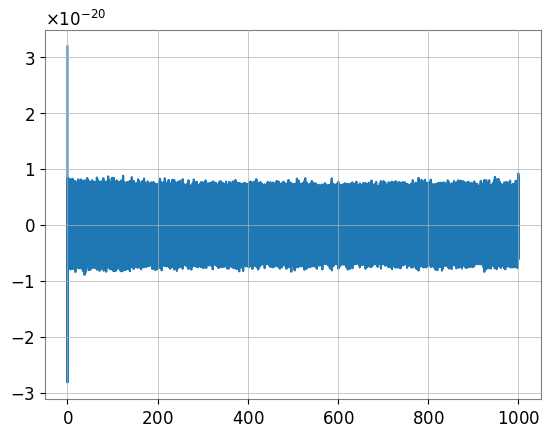

In [ ]:
#Reading the second dataset from LIGO Hanford
data2 = np.load('/content/drive/MyDrive/noise_ts_4096Hz.npy')

#Retrieving the Time and Strain data from the file
Time = data2[:, 0]
Strain = data2[:,1]

#Converting the data into time series data
import pycbc.types
DT = Time[1]-Time[0]
Data = pycbc.types.TimeSeries(data2[:,1], delta_t=DT)

strain = highpass(Data, 20.0)
strain = resample_to_delta_t(strain, 1.0/2048)
pylab.plot(strain.sample_times, strain)


In [ ]:
conditioned = strain.crop(2, 2)

mass1 = np.arange(5, 10,0.2 )
mass2 = mass1
Snr_list = []
#Generating a waveform in a loop to get all the masses
for i in range(len(mass1)):

    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=strain.delta_t,
                     f_lower=15)

    # Resizing to match the data
    hp.resize(len(conditioned))

    #template
    template = hp.cyclic_time_shift(hp.start_time)
    psd = conditioned.psd(4)
    psd = interpolate(psd, conditioned.delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

    #Filtering the template
    snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=15)
    snr = snr.crop(4 + 4, 4)
    Snr_list.append(max(abs(snr)))
snr = Snr_list

[5.03706473329517, 5.276443817060525, 5.59641678636811, 5.199614060098719, 5.936976196159866, 5.520225901699133, 5.309389327636596, 5.320365609447745, 5.2370951795767064, 5.791520392280747, 5.260812304420696, 5.723337079595333, 5.035048091428916, 5.167300872693812, 5.201143386318044, 5.820862384851329, 5.416692570017795, 5.250720255878152, 5.476164920512166, 5.288629352321421, 5.535350499215307, 6.787023167319755, 5.707892539834573, 6.190667384813289, 5.6672317987489995]


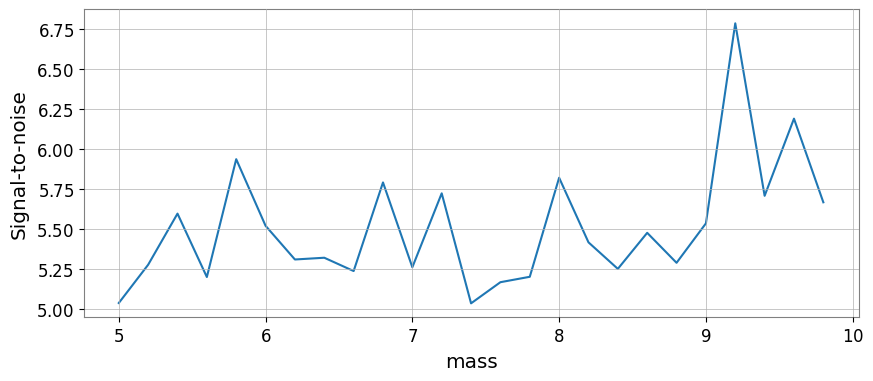

We found the best SNR was 9.20 solar masses 


<ipython-input-46-8fe40df0c746>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("We found the best SNR was %2.2f solar masses " % mass1[ii])


In [ ]:
print(snr)
nsnr = (np.array(snr)**2)**0.5
ii = np.where(nsnr == max(nsnr))
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, nsnr)

#Plotting
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

print("We found the best SNR was %2.2f solar masses " % mass1[ii])

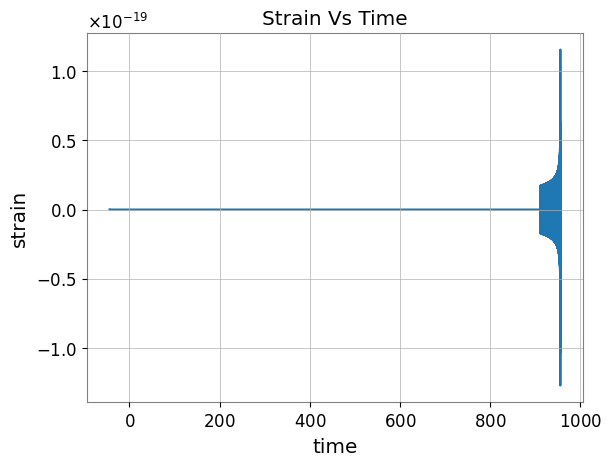

In [ ]:
#Getting the strain Vs time

m = 9.20 # Solar masses
conditioned = strain
hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=10.0)

# Resizing the vector to match the data
hp.resize(len(conditioned))

#Getting the template
template = hp .cyclic_time_shift(hp.start_time)

#Plotting the strain
pylab.plot(hp.sample_times, template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.title("Strain Vs Time after shifting")
pylab.show()

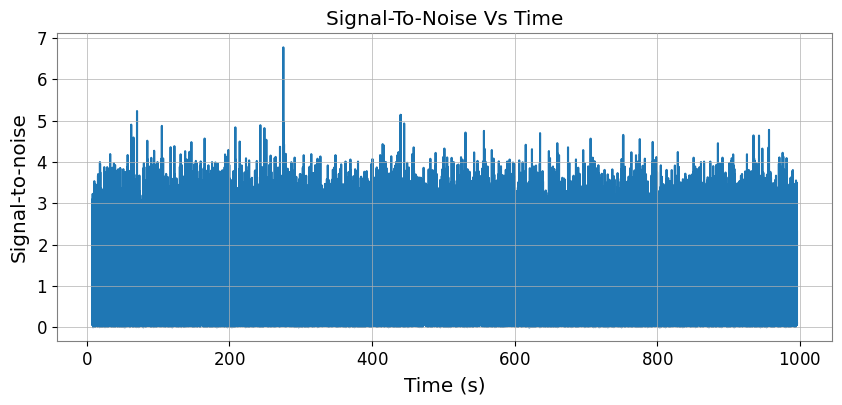

We found a signal at 275.66796875s with SNR 6.77622977887083
The data provided has only noise and no signal


In [ ]:
psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

#Filtering the template
snr = matched_filter(template, conditioned,
                  psd=psd, low_frequency_cutoff=15)
#Removing 4 seconds from the beginning and end for the PSD
snr = snr.crop(4 + 4, 4)

#Plotting the SNR to have real values only against time
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.title("Signal-To-Noise Vs Time")
pylab.show()

#Setting the parameters
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

print("The data provided has only noise and no signal")

Histogram of IQ, mean is 0.0014157725440332033


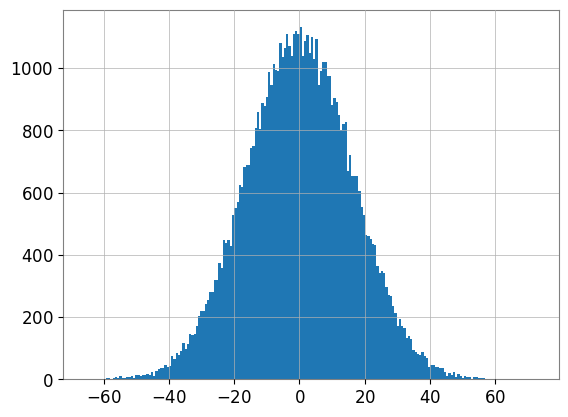

In [ ]:
#Problem 2 part 2
#Whitening the data

import pycbc.psd
from pycbc.psd import interpolate
delta_t = strain.delta_t
stilde =  strain.to_frequencyseries()
#segmenting the data
seg_len = int(2 / delta_t)
seg_stride = int(seg_len / 2)
Psds  = pycbc.psd.welch(strain,
                  seg_len=seg_len,
                  seg_stride=seg_stride)

Psds = interpolate(psd, stilde.delta_f)
aligned = template.cyclic_time_shift(DT)
# Whitening the data
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()

tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)


# Select the time around the merger
white_data = white_data.time_slice(10, 50)
white_template = white_template.time_slice(10, 50)

white_data = white_data.crop(4,4)

import statistics
import matplotlib.pyplot as plt

plt.hist(white_data,bins = 200)

print("Histogram of IQ, mean is " + str(statistics.mean(white_data)))


In [ ]:
#Problem 2 part 3
from scipy.optimize._lsq.common import print_header_nonlinear

#Calculating the optimal SNR
from pycbc.filter import sigmasq

from pycbc.waveform import get_fd_waveform


hp, hc = get_fd_waveform(approximant="TaylorF2",
                         mass1=3,
                         mass2=3,
                         delta_f=1.0/(200.0) ,
                         distance = 500,
                         f_lower=20.0, f_final = 2048.0)    #Luminosity distance = 500 Mpc

#Creating the SNR
SNR = (np.sum((4*hp*np.conj(hp)*hp.delta_f/psd).data).real)**0.5
#Error ValueError: different delta_f, otherwise supposed to plost the histogram of SNR
#Plotting the SNR
#plt.hist(SNR)

ValueError: different delta_f

In [ ]:
print(hp.delta_f)

0.005
